# Analysing the 'Loan Default Prediction - Imperial College London' data set from Kaggle

This notebook is used to analyzea set of financial transactions associated with individuals. The data set is available on [Kaggle](https://www.kaggle.com/c/loan-default-prediction/data) and was provided by the Imperial College London.

**In the original kaggle competition, participants had to predict loan default and the respective loss. In this notebook, we are only interested in predicting if a loan default will occur. This is why we do not use the test set from kaggle and work exclusively with the train set. Thus, the test set is created from this train set.**.

The data has been standardized, de-trended, and anonymized. It has over two hundred thousand observations and nearly 800 features. Each observation is independent from the previous. 

For each observation, it was recorded whether a default was triggered. In case of a default, the loss was measured. This quantity lies between 0 and 100. It has been normalised, considering that the notional of each transaction at inception is 100. For example, a loss of 60 means that only 40 is reimbursed. If the loan did not default, the loss was 0. Some variables may be categorical (e.g. f776 and f777).

The notebook is organized as follows:

1. Data exploration
2. Train ML model
3. Evaluate the ML model
4. Conclusion

----------

## 1. Data exploration

In this section, we import the train set and organize it. The test set is imported later. We set the cases where a loan default occured as the positive class (value equal to 1). 

The training set has 105471 and 771 features.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import imblearn

----------

### Getting the data

In [2]:
import warnings
warnings.filterwarnings("ignore")

data = pd.read_csv('/Users/leuzinger/Documentos/loan-default-prediction/train_v2.csv')
#data.reset_index(inplace=True)
#pd.set_option('display.max_columns', None)
#pd.set_option('display.max_rows', None)
data.head()

,id,f1,f2,f3,f4,f5,f6,f7,f8,f9,...,f770,f771,f772,f773,f774,f775,f776,f777,f778,loss
0,1,126,10,0.686842,1100,3,13699,7201.0,4949.0,126.75,...,5,2.14,-1.54,1.18,0.1833,0.7873,1,0,5,0
1,2,121,10,0.782776,1100,3,84645,240.0,1625.0,123.52,...,6,0.54,-0.24,0.13,0.1926,-0.6787,1,0,5,0
2,3,126,10,0.500080,1100,3,83607,1800.0,1527.0,127.76,...,13,2.89,-1.73,1.04,0.2521,0.7258,1,0,5,0
3,4,134,10,0.439874,1100,3,82642,7542.0,1730.0,132.94,...,4,1.29,-0.89,0.66,0.2498,0.7119,1,0,5,0
4,5,109,9,0.502749,2900,4,79124,89.0,491.0,122.72,...,26,6.11,-3.82,2.51,0.2282,-0.5399,0,0,5,0


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105471 entries, 0 to 105470
Columns: 771 entries, id to loss
dtypes: float64(653), int64(99), object(19)
memory usage: 620.4+ MB


In [4]:
import warnings
warnings.filterwarnings("ignore")

df = data.copy()

mask = df['loss'] != 0

df['default'] = df['loss']

df['default'][mask] = 1

------------

### Checking for imbalance

**We verify that the train set is clearly imbalanced**. There is 95688 cases in which a loan deafult did not happen and only 9783 loan deafult cases.

In [ ]:
df['default'].value_counts()

------------

### Data cleaning

First, we remove the columns with categorical variables. Then, we remove columns with a single value, and duplicated columns.

In [6]:
#check for categorical variables

cat = df.select_dtypes(include='object').columns

#remove columns with categorical variables
df = df.drop(cat,axis=1)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105471 entries, 0 to 105470
Columns: 753 entries, id to default
dtypes: float64(653), int64(100)
memory usage: 605.9 MB


In [8]:
from numpy import unique

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
single = []
for i in range(df.shape[1]):
    if len(unique(df.iloc[:, i])) == 1:
        single.append(df.iloc[:,i].name)
        
#remove columns with the same value in all rows
df = df.drop(['f33','f34','f35','f37','f38','f700','f701','f702','f736','f764'],axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105471 entries, 0 to 105470
Columns: 743 entries, id to default
dtypes: float64(653), int64(90)
memory usage: 597.9 MB


In [9]:
#check for duplicated rows
df.duplicated().any()

False

In [10]:
#check for duplicated columns
df.T.duplicated().any()

True

In [11]:
#store columns with int values (discrete variables)
col = df.select_dtypes(include='int64').columns

#remove columns duplicated
df = df.T.drop_duplicates().T
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105471 entries, 0 to 105470
Columns: 662 entries, id to default
dtypes: float64(662)
memory usage: 532.7 MB


----------

### Creating the Train and Test sets

Creating a test set at the beginning of the project avoid *data snooping* bias, i.e., "when you estimate the generalization error using the test set, your estimate will be too optimistic, and you will launch a system that will not perform as well as expected" (GÉRON, 2019).

In this project, the test set has already been created. It is imported later in the notebook. Therefore, we only need to create the X and Y training sets.

In [15]:
from sklearn.model_selection import train_test_split

loan_X = df.drop(['loss','default'],axis=1).copy()
loan_y = df['default'].copy()

loan_X_train, loan_X_test, loan_y_train, loan_y_test = train_test_split(loan_X, loan_y, test_size=0.2,stratify=loan_y)

---------

### Preparing the data for ML algorithms

Before creating the ML models, we need to prepare the data so that the ML algorithms will work properly.

First, we need to clean missing values from the dataset. Second, we need to put all the attributes in the same scale because "Machine Learning algorithms don’t perform well when the input numerical attributes have very different scales" (GÉRON, 2019).

**We check for NaN values distinguishing between discrete and continous variables because we would use different methods to inpute values depending on the type of the variable. However, we see that only the columns with continoues variables have missing values**.

We verify that 436 columns have at least one NaN value. Removing all the rows with NaN values, would result in losing more than 50% of the train set, which is not a good option. Therefore, we make the option to use statistical imputation to fill the NaN values. We use the mean value because all the NaN values are in columns with continous values. 

In [19]:
#check for columns with NaN values in the columns with discrete variables
col_=[]
colk = col[:-2]
for k in colk:
    if k in df.columns:
        col_.append(k)
        
len(list(loan_X_train[col_].columns[loan_X_train[col_].isnull().any()]))

0

In [20]:
#check for columns with NaN values in the columns with continous variables
len(list(loan_X_train[loan_X_train.columns.drop(col_)].columns[loan_X_train[loan_X_train.columns.drop(col_)].isnull().any()]))

436

In [21]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy='mean')
imputer.fit(loan_X_train)
loan_X_train_sp = imputer.transform(loan_X_train)

In [22]:
loan_X_train_sp = pd.DataFrame(loan_X_train_sp, columns = loan_X_train.columns)
len(list(loan_X_train_sp.columns[loan_X_train_sp.isnull().any()]))

0

In [23]:
loan_X_train_sp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84376 entries, 0 to 84375
Columns: 660 entries, id to f778
dtypes: float64(660)
memory usage: 424.9 MB


-------

### Dimensionality reduction

However, **using the train set with all the 105471 and 771 attributes requires a lot of computing power**. Therefore, we use a dimensionality reduction method to make the computation of the ML model less costly.

"Dimensionality reduction refers to techniques that reduce the number of input variables in a dataset. Fewer input dimensions often mean correspondingly fewer parameters or a simpler structure in the machine learning model, referred to as degrees of freedom. A model with too many degrees of freedom is likely to overfit the training dataset and therefore may not perform well on new data" ([BROWNLEE, 2021](https://machinelearningmastery.com/regression-metrics-for-machine-learning/)).

There are several techniques to reduce a data set dimensionality. **In this notebook, we use the Principal Component Analysis (PCA), which is the most used method for dimensionality reduction**. "It can be thought of as a projection method where data with m-columns (features) is projected into a subspace with m or fewer columns, whilst retaining the essence of the original data" (BROWNLEE, 2021). 

Moreover, it is "a good idea to normalize data prior to performing the PCA transform if the input variables have differing units or scales" (BROWNLEE, 2021), which is the case of our data set.

From the graph, we verify that it would be necessary around 250 components to account to 99% of the variance, 100 for 90% and 50 for 80%. **We use in this project 34 components, which account for 75% of the variance, because of our limited computing power**.

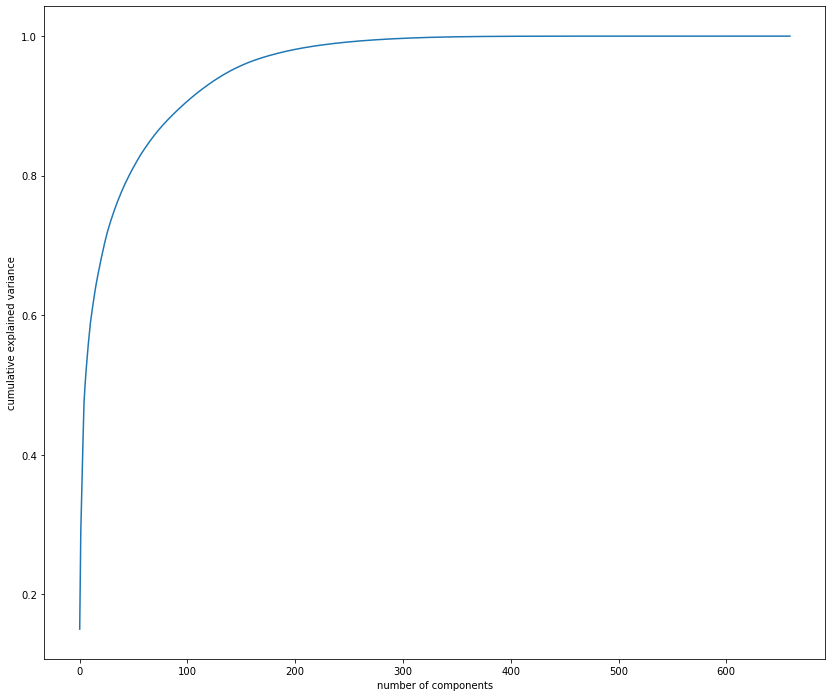

In [24]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(loan_X_train_sp)
loan_X_train_scl = scaler.transform(loan_X_train_sp)
pca = PCA().fit(loan_X_train_scl)
plt.figure(figsize=(14,12))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.show()

In [25]:
pca = PCA(0.75)
pca.fit(loan_X_train_scl)
len(pca.explained_variance_ratio_)

34

In [28]:
from sklearn.pipeline import Pipeline

pca_scaler = Pipeline(steps=[('scaler',StandardScaler()),('pca', PCA(0.75))])

pca_scaler.fit(loan_X_train_sp)
loan_X_train_pca = pca_scaler.transform(loan_X_train_sp)

----------

## 2. Train ML model

After preparing the data set, we are ready to select and train our ML model.

Evaluating a classifier is often trickier than evaluating other ML models."This challenge is made even more difficult when there is a skew in the class distribution. The reason for this is that many of the standard metrics become unreliable or even misleading when classes are imbalanced, or severely imbalanced, such as 1:100 or 1:1000 ratio between a minority and majority class" [(BROWNLEE, 2020)](https://machinelearningmastery.com/imbalanced-classification-with-python/).

The main evaluation metrics for imbalanced data sets can be divided into (BROWNLEE, 2020):

1. Threshold Metrics - F-score, G-mean 
2. Ranking Metrics - Precision-Recall Area Under Curve (PR AUC), Receiver Operating Characteristic AUC (ROC AUC)
3. Probability Metrics - LogLoss score, Brier score

**We use the F2-score (less weight on precision, but more weight on recall in comparison to the F1-score) as the evaluation metric because we are predicting labels and false negatives are more costly than false positives**. False negatives are more costly because they mean not identifying cases in which a loan default may occur, while incorrect denial of a loan when default is not likely (false positive) has a much lower cost. 

Besides, "the key to a fair comparison of machine learning algorithms is ensuring that each algorithm is evaluated in the same way on the same data. You can achieve this by forcing each algorithm to be evaluated on a consistent test harness" (BROWNLEE, 2016). In this project, we do this by using the same split in the cross validation. We use the KFold function from the sklearn library with a random value rs as the random_state parameter. Although the rs value change everytime the notebook is run, once it is set, the same rs value is used in all the models. This guarantees that all the models are evaluated on the same data. 

--------

### Spot-check algorithms

Then we spot-check some algorithms, i.e., we evaluate some algotithms with minimum hyperparameter tuning to see  how they perform. "The objective is to quickly test a range of standard machine learning algorithms and provide a baseline in performance to which techniques specialized for imbalanced classification must be compared and outperform in order to be considered skillful" (BROWNLEE, 2020).

First, we evaluate a naive algorithm, which provides a baseline in performance that any algorithm must overcome in order to have skill on the dataset (BROWNLEE, 2020). We use a naive algorithm that predicts the minority class (class 1), as we are using a F-score metric to evaluate the models.

Then we check two linear machine learning algorithms:

1. Logistic Regression (LogR). "Logistic regression assumes a Gaussian distribution for the numeric input variables and can model binary classification problem" (BROWNLEE, 2016). "It is commonly used to estimate the probability that an instance belongs to a particular class" (GÉRON, 2019).
2. Linear Discriminant Analysis (LDA). This is a statistical technique for binary and multiclass classification (BROWNLEE, 2016).

Finally, we try some nonlinear machine learning algorithms:

3. k-Nearest Neighbors (KNN). This model "locates the k most similar instances in the training dataset for a new data instance" (BROWNLEE, 2016).
4. Naive Bayes. This method "calculates the probability of each class and the conditional probability of each class given each input value. These probabilities are estimated for new data and multiplied together, assuming that they are all independent (a simple or naive assumption)" (BROWNLEE, 2016). 
5. Decision Tree. It uses "the train- ing data to select the best points to split the data in order to minimize a cost metric" (BROWNLEE, 2016).

**The results show that none of the algorithms tested performed better than the naive algorithm**. Besides, the box and whisker plots for each algorithm’s results are created, showing the difference in mean performance (green triangles) and the similar spread in scores between the methods. This suggests all methods have similar distributions. LogR and LDA are slightly more compact, but have performed much worse than the other methods.


Therefore, we need to try other algorithms for this problem.

In [29]:
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import fbeta_score
from sklearn.metrics import make_scorer
import warnings

warnings.filterwarnings("ignore")

def f2_measure(y_true, y_pred):
    return fbeta_score(y_true, y_pred, beta=2)

def evaluation(model,X_train,y_train,rs):
    #model.fit(X_train,y_train)
    #yhat_train = model.predict(X_train)
    f2_score = make_scorer(f2_measure)
    kfold = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=rs)
    results_f2 = cross_val_score(model, X_train, y_train, cv=kfold, scoring=f2_score, n_jobs=-1)
    #print('F2_score: %.6f (%.6f)\n' % (results_f2.mean(), results_f2.std()))
    return results_f2

In [30]:
from random import randrange

rs = randrange(10000)

In [31]:
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier

result = pd.DataFrame(columns=['model','F2-score mean','F2-socre std'])

models = [DummyClassifier(strategy='constant',constant=1),LogisticRegression(),LinearDiscriminantAnalysis(),
          KNeighborsClassifier(),GaussianNB(),DecisionTreeClassifier()
         ]
models_str = ['Naive','LogR','LDA','KNN','GaussianNB','Decision Tree']
results_list = list()

for k in range(len(models)):
    results = evaluation(models[k],loan_X_train_pca,loan_y_train,rs)
    results_list.append(results)
    results_ = [models_str[k],results.mean(),results.std()]
    results_ = pd.Series(results_, index = result.columns)
    result = result.append(results_,ignore_index=True)
result

,model,F2-score mean,F2-socre std
0,Naive,0.338261,0.000140
1,LogR,0.000319,0.000639
2,LDA,0.001064,0.001324
3,KNN,0.021940,0.005752
4,GaussianNB,0.091774,0.009072
5,Decision Tree,0.139281,0.012772


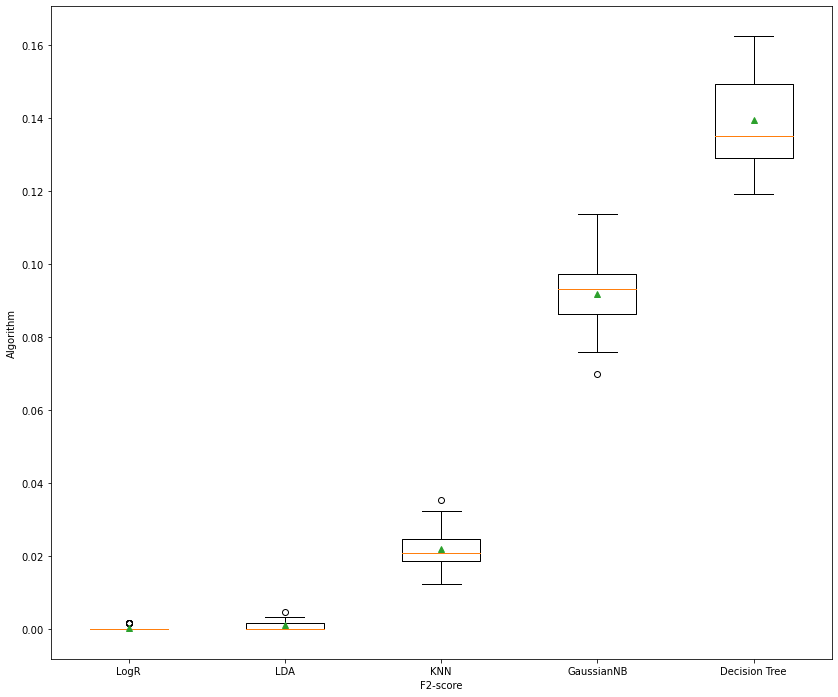

In [32]:
plot_list = results_list[1:]
labels = models_str[1:]

plt.figure(figsize=(14,12))
plt.boxplot(results_list[1:],labels=models_str[1:],showmeans=True)
plt.xlabel('F2-score')
plt.ylabel('Algorithm')
plt.show()

-----

### Spot-check imbalanced algorithms

This part is similar to the preivous one. "**The objective is to quickly test a large number of techniques in order to discover what shows promise**" (BROWNLEE, 2020). Then we can focus on the best ones later during hyperparameter tuning.

**We start our anlysis with cost-sensitive algorithms**, i.e., algorithms "that takes the costs of prediction errors (and potentially other costs) into account when training a machine learning model" (BROWNLEE, 2020). When dealing with imbalanced classification problems, not all erros are equal. Therefore, we nedd to assign different costs to the types of misclassification errors that can be made (BROWNLEE, 2020). However, "machine learning algorithms are rarely developed specifically for cost-sensitive learning. Instead, the wealth of existing machine learning algorithms can be modified to make use of the cost matrix"(BROWNLEE, 2020). The cost matrix assigns a cost to each ceel in the confusion matrix. 

We try the following cost-sensitive algorithms:

1. Logistic Regression (LogR). Although LogR does not support imbalanced classification directly, it can be adapted by specifying a class weighting to penalize the model more for errors made in the minority class(BROWNLEE, 2020).
2. Decision Trees. These algorithms also does not perform well on imbalanced datasets. It is necessary to modify the criterion used to evaluate split points so that it takes into account the importance of each classclass (BROWNLEE, 2020). 

We also try ensemble algorithms, i.e, algorithms "that fits multiple models on different subsets of a training dataset, then combines the predictions from all models" (BROWNLEE, 2020):

3. Random Forest. It selects random samples with replacement (bootsrap samples) and fits a decision tree on each. However, not all features are used, only a small subset of features is selected for each bootstrap sample (BROWNLEE, 2020).
4. Easy Ensemble. This algorithm creates balanced samples of the treining dataset by selecting examples form the minority class and a subset of the majority class. Then, it uses boosted decion trees on each subset, specifically the AdaBoost algorithm. The process is repeated for a given number of descion trees (BROWNLEE, 2020).


**The results show that Logistic Regression, Random Forest and Easy Ensemble algorithms performed better than the naive algorithm**. We see in the box and whisker plot that the the distribution for all these algorithms is compact and skillful. We can try to improve their perfomance by tuning the hyperparameters.

In [64]:
results_RF = evaluation(BalancedRandomForestClassifier(n_estimators=1000),loan_X_train_pca,loan_y_train,rs)
print(results_RF.mean(),results_RF.std())

0.38113838057024957 0.010829407212496771


In [57]:
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from imblearn.ensemble import EasyEnsembleClassifier, BalancedRandomForestClassifier

result_im = pd.DataFrame(columns=['model','F2-score mean','F2-socre std'])

models_im = [LogisticRegression(solver='lbfgs', class_weight='balanced'),DecisionTreeClassifier(class_weight='balanced'),
          BalancedRandomForestClassifier(),EasyEnsembleClassifier()
         ]
models_str_im = ['LogR balanced','Decision Tree balanced','Random Forest','Easy Ensemble']

results_list_im = list()

for k in range(len(models_im)):
    results_im = evaluation(models_im[k],loan_X_train_pca,loan_y_train,rs)
    results_list_im.append(results_im)
    results_im_ = [models_str_im[k],results_im.mean(),results_im.std()]
    results_im_ = pd.Series(results_im_, index = result_im.columns)
    result_im = result_im.append(results_im_,ignore_index=True)
result_im

,model,F2-score mean,F2-socre std
0,LogR balanced,0.380819,0.011552
1,Decision Tree balanced,0.127109,0.009409
2,Random Forest,0.369469,0.010544
3,Easy Ensemble,0.378675,0.011392


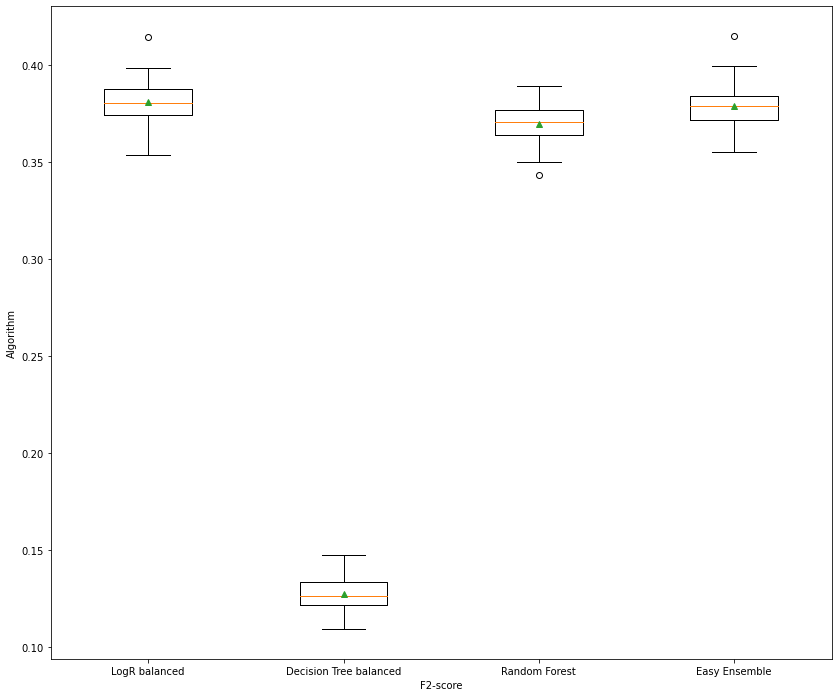

In [58]:
plt.figure(figsize=(14,12))
plt.boxplot(results_list_im,labels=models_str_im,showmeans=True)
plt.xlabel('F2-score')
plt.ylabel('Algorithm')
plt.show()

### Algorithm Tuning

In this section, we are interested in tuning and comparing different parameter settings to further improve the performance for making predictions on unseen data. "This process is called model selection, with
the name referring to a given classification problem for which we want to select the optimal values of tuning parameters (also called hyperparameters)" (RASCHKA; MIRJALILI, 2019).

First, we verify which weight are being used in the 'balanced' LogR model from sklearn. Then, we test some other weights to see how the model perform.

**We verifiy that the best parameters for the LogR model are class_weight = {0: 1, 1: 10}, and solver= lbfgs**.

In [35]:
# calculate heuristic class weighting
from sklearn.utils.class_weight import compute_class_weight
from sklearn.datasets import make_classification
# generate 2 class dataset

weighting = compute_class_weight('balanced', [0,1], loan_y_train)
weighting

array([0.55111692, 5.39074879])

In [36]:
from sklearn.model_selection import GridSearchCV

# define model and parameters
model = LogisticRegression(solver='lbfgs')
solver = ['lbfgs','liblinear']
balance = [{0:1,1:1},{0:1, 1:9.78056972},{0:1,1:10},{0:1,1:15},{0:1,1:25},{0:1,1:50},
           {0:1,1:100}
          ]
f2_score = make_scorer(f2_measure)

# define grid search
grid = dict(solver=solver,class_weight=balance)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=rs)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring=f2_score)
grid_result = grid_search.fit(loan_X_train_pca,loan_y_train)

# summarize results
means_f2 = grid_result.cv_results_['mean_test_score']
stds_f2 = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean_f2, stdev_f2,param in zip(means_f2, stds_f2, params):
    print("%f (%f) with: %r" % (mean_f2, stdev_f2, param))

0.000000 (0.000000) with: {'class_weight': {0: 100, 1: 1}, 'solver': 'lbfgs'}
0.000000 (0.000000) with: {'class_weight': {0: 100, 1: 1}, 'solver': 'liblinear'}
0.000000 (0.000000) with: {'class_weight': {0: 50, 1: 1}, 'solver': 'lbfgs'}
0.000000 (0.000000) with: {'class_weight': {0: 50, 1: 1}, 'solver': 'liblinear'}
0.000000 (0.000000) with: {'class_weight': {0: 10, 1: 1}, 'solver': 'lbfgs'}
0.000000 (0.000000) with: {'class_weight': {0: 10, 1: 1}, 'solver': 'liblinear'}
0.000319 (0.000639) with: {'class_weight': {0: 1, 1: 1}, 'solver': 'lbfgs'}
0.000319 (0.000639) with: {'class_weight': {0: 1, 1: 1}, 'solver': 'liblinear'}
0.380792 (0.011572) with: {'class_weight': {0: 0.55111692, 1: 5.39074879}, 'solver': 'lbfgs'}
0.380777 (0.011577) with: {'class_weight': {0: 0.55111692, 1: 5.39074879}, 'solver': 'liblinear'}
0.382306 (0.011061) with: {'class_weight': {0: 1, 1: 10}, 'solver': 'lbfgs'}
0.382269 (0.011053) with: {'class_weight': {0: 1, 1: 10}, 'solver': 'liblinear'}
0.345261 (0.000663

In [65]:
model = EasyEnsembleClassifier(random_state=rs)
n_estimators = [10, 15, 20]
f2_score = make_scorer(f2_measure)

# define grid search
grid = dict(n_estimators=n_estimators)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=rs)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring=f2_score)
grid_result = grid_search.fit(loan_X_train_pca,loan_y_train)

# summarize results
means_f2 = grid_result.cv_results_['mean_test_score']
stds_f2 = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean_f2, stdev_f2,param in zip(means_f2, stds_f2, params):
    print("%f (%f) with: %r" % (mean_f2, stdev_f2, param))

0.378032 (0.010667) with: {'n_estimators': 10}
0.379094 (0.010297) with: {'n_estimators': 15}
0.378106 (0.010881) with: {'n_estimators': 20}


In [68]:
model = BalancedRandomForestClassifier(random_state=rs)
n_estimators = [100,500,1000]
f2_score = make_scorer(f2_measure)

# define grid search
grid = dict(n_estimators=n_estimators)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=rs)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring=f2_score)
grid_result = grid_search.fit(loan_X_train_pca,loan_y_train)

# summarize results
means_f2 = grid_result.cv_results_['mean_test_score']
stds_f2 = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean_f2, stdev_f2,param in zip(means_f2, stds_f2, params):
    print("%f (%f) with: %r" % (mean_f2, stdev_f2, param))

0.370558 (0.009277) with: {'n_estimators': 100}
0.379545 (0.009527) with: {'n_estimators': 500}
0.381304 (0.010557) with: {'n_estimators': 1000}


-------

### Data Sampling

"Data sampling provides a collection of techniques that transform a training dataset in order to balance or better balance the class distribution" (BROWNLEE, 2020). There are several data sampling methods to choose from. There are two types of data sampling: oversampling and under sampling. "Oversampling methods duplicate examples in the minority class or synthesize new examples from the examples in the minority class" (BROWNLEE, 2020). On the other hand, "undersampling methods delete or select a subset of examples from the majority class"(BROWNLEE, 2020). Besides, it is possible to combine oversampling and undersampling methods.

**There is no best data sampling method, but oversampling is much more used than undersampling. Besides, undersampling methods are slow and more suited to small data sets, which is not the case in this project**. Thus, we try the following oversampling methods:

1. Random Oversampling (ROS). Randomly duplicate examples in the minority class
2. Synthetic Minority Oversampling Technique (SMOTE). "SMOTE first selects a minority class instance a at random and finds its k nearest minority class neighbors. The synthetic instance is then created by choosing one of the k nearest neighbors b at random and connecting a and b to form a line segment in the feature space. The synthetic instances are generated as a convex combination of the two chosen instances a and b" [(HE; MA, 2013)](https://www.amazon.com.br/Imbalanced-Learning-Foundations-Algorithms-Applications/dp/1118074629).
3. Borderline-SMOTE (BLSMOTE). "A popular extension to SMOTE involves selecting those instances of the minority class that are misclassified, such as with a k-nearest neighbor classification model" (BROWNLEE, 2020).
4. Adaptive Synthetic Sampling (ADASYN). A modification of SMOTE that "involves generating synthetic samples inversely proportional to the density of the examples in the minority class" (BROWNLEE, 2020).

**We verify that BLSMOTE has the best performance, even though having a higher standard deviation, as can be seen in the box and whisker plot. However, BLSMOTE has not improved the performance of our model**.

In [37]:
from imblearn.over_sampling import RandomOverSampler, SMOTE, BorderlineSMOTE, SVMSMOTE, ADASYN
from imblearn.pipeline import Pipeline

# define oversampling models
result_over = pd.DataFrame(columns=['oversampling','F2-score mean','F2-socre std'])
models_over = [RandomOverSampler(),SMOTE(),BorderlineSMOTE(),ADASYN()]
models_str_over = ['ROS','SMOTE','BLSMOTE','ADASYN']
results_list_over = list()

# evaluate each model
for k in range(len(models_over)):
    model_over = LogisticRegression(solver='lbfgs', class_weight={0: 1, 1: 10})
    
    #define the pipeline
    steps = [('o', models_over[k]), ('m', model_over)] 
    pipe_over = Pipeline(steps=steps)

    results_over = evaluation(pipe_over,loan_X_train_pca,loan_y_train,rs)
    results_list_over.append(results_over)
    results_over_ = [models_str_over[k],results_over.mean(),results_over.std()]
    results_over_ = pd.Series(results_over_, index = result_over.columns)
    result_over = result_over.append(results_over_,ignore_index=True)

result_over

,oversampling,F2-score mean,F2-socre std
0,ROS,0.339766,0.000397
1,SMOTE,0.342185,0.000516
2,BLSMOTE,0.348729,0.001167
3,ADASYN,0.341525,0.000534


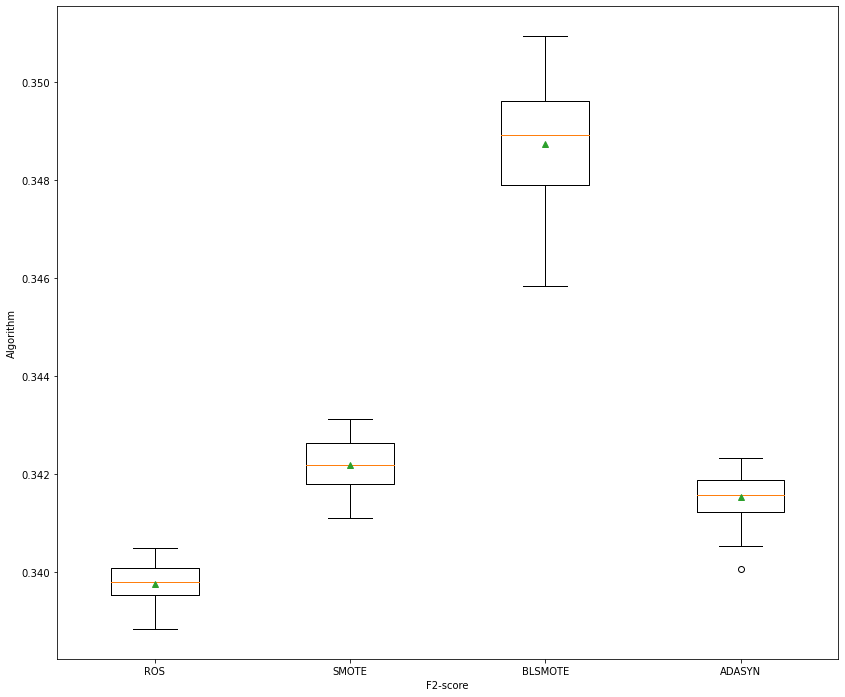

In [38]:
plt.figure(figsize=(14,12))
plt.boxplot(results_list_over,labels=models_str_over,showmeans=True)
plt.xlabel('F2-score')
plt.ylabel('Algorithm')
plt.show()

---------

# 3. Evaluate the ML model

Now evaluate the performance of our ML model in the test set, to see how it perform with unseen data.

First, we prepare the X_test data as we did with the X_train data.

Then, we test the our model. **We verify that our model performed well with the test set, with a F2-score much better than the Naive algorithm. Moreover, the model performed slightly better than in the tests with the train set**.

F2-score: 0.390990


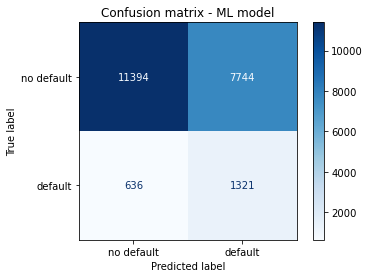

In [66]:
from sklearn.metrics import plot_confusion_matrix

imputer = SimpleImputer(strategy='mean')
LR = LogisticRegression(solver='lbfgs', class_weight={0: 1, 1: 10})

steps=[('imputer',imputer),('scaler',StandardScaler()),('pca', PCA(0.75)), ('m', LR)]
pipe_ML = Pipeline(steps=steps)
pipe_ML.fit(loan_X_train,loan_y_train)

loan_yhat_test = pipe_ML.predict(loan_X_test)
#loan_yprob_test = pipe_ML.predict_proba(loan_X_test)[:,1]

f2_score = fbeta_score(loan_y_test, loan_yhat_test, beta=2)

print('F2-score: %.6f' % f2_score)


class_names = ['no default','default']
disp = plot_confusion_matrix(pipe_ML,loan_X_test,loan_y_test,
                             display_labels=class_names,
                             cmap=plt.cm.Blues,
                             )
disp.ax_.set_title("Confusion matrix - ML model")

plt.show()

F2-score: 0.338312


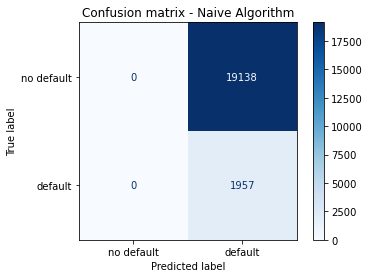

In [67]:
imputer = SimpleImputer(strategy='mean')
naive = DummyClassifier(strategy='constant',constant=1)

steps=[('imputer',imputer),('scaler',StandardScaler()),('pca', PCA(0.75)), ('m', naive)]
pipe_NA = Pipeline(steps=steps)
pipe_NA.fit(loan_X_train,loan_y_train)

loan_yhat_test = pipe_NA.predict(loan_X_test)
#loan_yprob_test = pipe_ML.predict_proba(loan_X_test)[:,1]

f2_score = fbeta_score(loan_y_test, loan_yhat_test, beta=2)

print('F2-score: %.6f' % f2_score)


class_names = ['no default','default']
disp = plot_confusion_matrix(pipe_NA,loan_X_test,loan_y_test,
                             display_labels=class_names,
                             cmap=plt.cm.Blues,
                             )
disp.ax_.set_title("Confusion matrix - Naive Algorithm")

plt.show()

----------------------

## 4. Conclusion

In this notebook, we create a model to predict if a loan default will occur. 

We start the notebook with a dimensionality reduction using PCA because our data set had too many features and our computing power is limited. We reduce the dimensionality of the data set from 660 to 34 maintaining 75% of the variance explicability.

Next, we test some classification algorithms: 

1. Logistic Regression (LR)
2. Linear Discriminant Analysis (LDA)
3. k-Nearest Neighbors (KNN)
4. Naive Bayes
5. Decision Tree

Then, we test some imbalacend algorithms:

1. Balanced Logistic Regression
2. Balanced Decision Tree
3. Random Forest
4. Easy Ensemble

Finaly, we test some oversampling methods:

1. Random Oversampling (ROS)
2. Synthetic Minority Oversampling Technique (SMOTE)
3. Border Line SMOTE (BLSMOTE)
4. Adaptive Synthetic Sampling (ADASYN)

We verify that the best ML model for the train set is a Balanced LogR combined without oversampling.

**We see that the ML model performed well with the test set, with a F2-score slightly better than in the tests with the train set. The model predicted correctly 1321 default loans out of 1957. Thus, only 636 default loans were not predicted correclty**.

The model can be improved by increasing the dimensionality in the PCA (or even using all features) or testing the Random Forest and Easy Ensemble algorithms with more estimators. Again, this was not possible in this notebook becasue we have limeted computing power.